- Student 1: Abdulmohsen Abanmy - 201920790
- Student 2: Faisal Alzahrani - 201829740

# Part A

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

np.random.seed(4444)

#### Dataset analysis

In [2]:
dataset = pd.read_csv('Dataset-vf.csv')
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6124 entries, 0 to 6123
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X5      6124 non-null   int64  
 1   X2      5520 non-null   float64
 2   X3      6124 non-null   int64  
 3   X4      6124 non-null   int64  
 4   X6      6124 non-null   int64  
 5   X1      6124 non-null   int64  
 6   X10     6124 non-null   int64  
 7   X7      6124 non-null   int64  
 8   X8      6124 non-null   int64  
 9   X9      6124 non-null   int64  
 10  X11     6124 non-null   float64
 11  X12     6124 non-null   int64  
 12  X15     601 non-null    object 
 13  X13     6124 non-null   object 
 14  X14     6124 non-null   object 
 15  Y       6124 non-null   object 
dtypes: float64(2), int64(10), object(4)
memory usage: 765.6+ KB


None

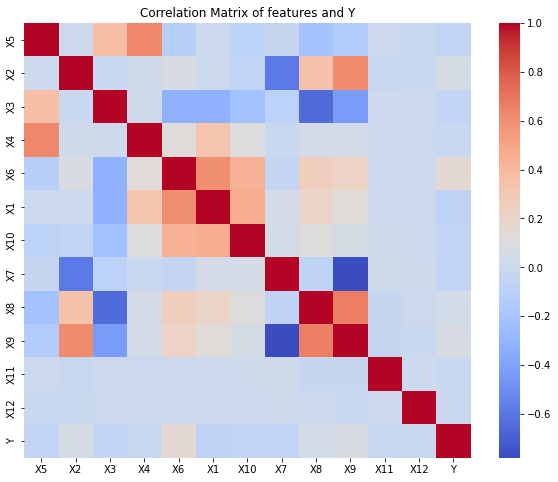

Top 5 correlated columns with 'Y':

Feature: X6, Correlation: 16%
Feature: X1, Correlation: 8%
Feature: X9, Correlation: 7%
Feature: X10, Correlation: 6%
Feature: X7, Correlation: 6%


In [4]:
# Only analysis view, next cells will start from the begining.
df = dataset.copy()

car_map = {car: i for i, car in enumerate(np.unique(df['Y']))}
df.replace(car_map, inplace=True)

# Only use numerical columns for viewing purposes 
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df = df[numerical_cols]

correlation_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of features and Y')
plt.show()

top_correlated_columns = correlation_matrix.abs()['Y'].sort_values(ascending=False).head(6)
print("Top 5 correlated columns with 'Y':\n")
print(*(f"Feature: {feature}, Correlation: {correlation:.0%}" for feature, correlation in zip(top_correlated_columns.index, top_correlated_columns) if feature != 'Y'), sep="\n")

In [5]:
display(df.head())

,X5,X2,X3,X4,X6,X1,X10,X7,X8,X9,X11,X12,Y
0,43,59.0,11,120,150,2709,2114,228,217,120,0.66,269,0
1,0,54.0,7,0,693,2802,162,224,225,136,0.35,195,0
2,0,28.0,12,0,1260,2325,162,215,213,133,0.89,750,4
3,16,112.0,8,272,3649,2837,6221,235,231,128,0.27,-155,1
4,10,59.0,7,134,900,2509,5184,226,226,134,0.93,88,0


## Preprocessing

Missing values:
- For X2, the missing value percentage is around 10%, so we will fill it with the mean of the column.
- For X15, only 10% of the data remain, so we will drop the column.

In [6]:
df = dataset.copy()
print(f"Raw dataset shape: {dataset.shape}")

# Handling NaN values

## Undersample the whole dataset to match the imbalanced columns
# df.dropna(inplace=True)

## Upsample the imbalanced columns to match the others.
# df['X2'].fillna(df['X2'].mean(), inplace=True)
# df['X15'].fillna(df['X15'].mod(), inplace=True)

## Hybrid (upsample and remove a column based on the amount of real data)
df['X2'].fillna(df['X2'].mean(), inplace=True)
df.drop(columns=['X15'], inplace=True)

Raw dataset shape: (6124, 16)


1. Feature Transformation
    - Scaling the Data.
    - One Hot Encoding Categorical variables.

In [7]:
# Applying Scaler
scaler = StandardScaler()
df.iloc[:,:12] = scaler.fit_transform(df.iloc[:,:12])


# Number labeling output
car_map = {car: i for i, car in enumerate(np.unique(df['Y']))}
df.replace(car_map, inplace=True)

# One hot encode
encoder = OneHotEncoder(sparse_output=False)
categorical_columns = df.select_dtypes(include=['object']).columns

encoded_data = encoder.fit_transform(df[categorical_columns])
df.drop(columns=categorical_columns, inplace=True) # Drop the categorical columns to replace them with encoded columns
df[encoder.get_feature_names_out()] = encoded_data

# Reorder so Y is the last index
columns = df.columns.drop('Y').tolist()
columns.append('Y')
df = df[columns]

2. Feature Selection
    - RFE using RandomForestClassifier to get the most important features.

In [8]:
# Feature Selection
X = df.iloc[:,:-1].copy()
y =  df.iloc[:,-1].copy()
print(f"X shape: {X.shape}, y shape: {y.shape}")

# # Assuming X is your features and y is your target variable
# estimator = RandomForestClassifier(n_estimators=50)
# selector = RFE(estimator, n_features_to_select=25, step=2)
# selector = selector.fit(X, y)
# selected_features = X.columns[selector.support_]
# X = X[selected_features]

# print("After Feature Selection:")
# print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (6124, 48), y shape: (6124,)


3. Feature Engineering
    - Exteding the data using polynomial features

In [9]:
poly = PolynomialFeatures(degree=1)
X = poly.fit_transform(X)
print("After polynomial expansion:")
print(f"X shape: {X.shape}, y shape: {y.shape}")

After polynomial expansion:
X shape: (6124, 49), y shape: (6124,)


In [10]:
# First, split into train and temp sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, train_size=0.5)

print(f"Train:")
print(f"\tX shape: {X_train.shape}\t y shape: {y_train.shape})")
print(f"Validation:")
print(f"\tX shape: {X_valid.shape}\t y shape: {y_valid.shape})")
print(f"Test:")
print(f"\tX shape: {X_test.shape}\t y shape: {y_test.shape})")

Train:
	X shape: (4286, 49)	 y shape: (4286,))
Validation:
	X shape: (919, 49)	 y shape: (919,))
Test:
	X shape: (919, 49)	 y shape: (919,))


#### Model Evaluation method

In [11]:
def get_score(y_real, y_pred):

    # Calculate evaluation metrics
    f1_macro = f1_score(y_real, y_pred, average='macro') # F1 will be the main score because it encapsulates all other data.
    precision = precision_score(y_real, y_pred, average='macro')
    recall = recall_score(y_real, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred) 
    
    return f1_macro, precision, recall, conf_matrix

def show_results(model, X, y):
    
    f1, precision, recall, conf_matrix = get_score(y, model.predict(X))
    
    print("Statistics:")
    print(f"\tF1-Score: {f1:.2%}")
    print(f"\tPrecision: {precision:.2%}, \tRecall: {recall:.2%}")
    print()

    # Create a confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    classes = car_map.keys()
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Models

- no polynomial features, only taking 15 best features according to RFE, best F-1 = 87.69
- Polynomial features only enhanced the F-1 score by 0.1%, so it is not effective.
- Using all of the data (not using feature selection) increased the F-1 to 90.02

KNN (Abdulmohsen)

In [12]:
from sklearn.neighbors import KNeighborsClassifier

# Hyperparam search
for k in range(1, 30, 2):
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = f1_score(y_valid, knn.predict(X_valid), average='macro')
    print(f"K-{k}\tF1: {score:.2%}")

K-1	F1: 80.94%
K-3	F1: 83.10%
K-5	F1: 81.28%
K-7	F1: 80.18%
K-9	F1: 78.10%
K-11	F1: 76.04%
K-13	F1: 74.04%
K-15	F1: 73.35%
K-17	F1: 71.91%
K-19	F1: 70.54%
K-21	F1: 67.23%
K-23	F1: 65.65%
K-25	F1: 65.15%
K-27	F1: 68.03%
K-29	F1: 67.34%


In [13]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

# Predictions and accuracy for KNN
y_pred = knn.predict(X_test)

f1, precision, recall, conf_matrix = get_score(y_test, y_pred)

print(f"Validation F1-Score: {f1:.2%}")

Validation F1-Score: 81.03%


RandomForestClassifier (Abdulmohsen)

In [14]:
# Hyperparam search

# After broad examination, the best n_estimators was found to be 100 (default)
# Best loss is entropy
# Best max depth is 30 (default)
for loss in ['gini', 'entropy', 'log_loss']:
    print("Loss:", loss)
    for max_depth in range(10, 50, 10):
        print("\tMax Depth:", max_depth)
    
        rf = RandomForestClassifier(criterion=loss, max_depth=max_depth, min_samples_split=2, min_samples_leaf=2, random_state=4444)
        rf.fit(X_train, y_train)
        score = f1_score(y_valid, rf.predict(X_valid), average='macro')
        print(f"\t\tF1: {score:.2%}")

   

Loss: gini
	Max Depth: 10
		F1: 88.36%
	Max Depth: 20
		F1: 89.22%
	Max Depth: 30
		F1: 90.23%
	Max Depth: 40
		F1: 90.23%
Loss: entropy
	Max Depth: 10
		F1: 88.60%
	Max Depth: 20
		F1: 90.42%
	Max Depth: 30
		F1: 91.17%
	Max Depth: 40
		F1: 91.17%
Loss: log_loss
	Max Depth: 10
		F1: 88.60%
	Max Depth: 20
		F1: 90.42%
	Max Depth: 30
		F1: 91.17%
	Max Depth: 40
		F1: 91.17%


In [15]:
# Random Forest Classifier
rf = RandomForestClassifier(min_samples_split=2, min_samples_leaf=2, random_state=4444)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_valid)

f1, precision, recall, conf_matrix = get_score(y_valid, y_pred)

print(f"Validation F1-Score: {f1:.2%}")

Validation F1-Score: 90.23%


---

## Model Testing

Best model is: <class 'sklearn.ensemble._forest.RandomForestClassifier'> with validation score of: 90.23%
Testing the model on test data...
Statistics:
	F1-Score: 87.51%
	Precision: 91.59%, 	Recall: 85.34%



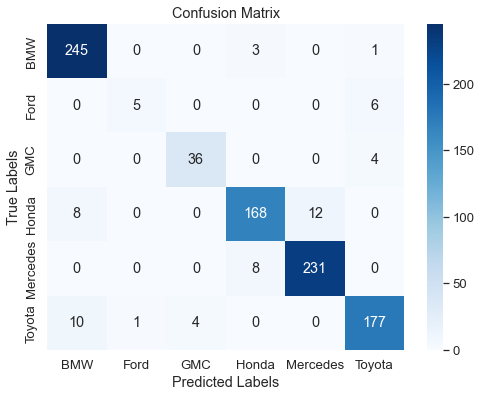

In [16]:
models = [knn, rf]

best_score = 0
best_model = None

for model in models:
    score = get_score(y_valid, model.predict(X_valid))[0]
    if score > best_score:
        best_score = score
        best_model = model

print(f"Best model is: {type(model)} with validation score of: {best_score:.2%}")
print("Testing the model on test data...")
show_results(model, X_test, y_test)

# Part B

Least confidence (Abdulmohsen)

In [17]:
# Generate a synthetic dataset for demonstration (replace with your own dataset)
X_pool = X_train.copy()
y_pool = np.array(y_train.copy())

# Start with a small labeled dataset
initial_indices = np.random.choice(range(len(X_pool)), size=100, replace=False)
X_initial = X_pool[initial_indices]
y_initial = y_pool[initial_indices]

# Remove the initial labeled set from the pool
X_pool = np.delete(X_pool, initial_indices, axis=0)
y_pool = np.delete(y_pool, initial_indices, axis=0)

rf = RandomForestClassifier(min_samples_split=2, min_samples_leaf=2, random_state=4444)
scores = []

# Active learning loop
for iteration in range(1000):
    rf.fit(X_initial, y_initial)

    probs = rf.predict_proba(X_pool)
    least_conf_idx = np.argmin(np.max(probs, axis=1)) # Takes the correctly predicted classes, then get the one with the least confidence

    # Add the selected sample to the labeled set
    X_initial = np.vstack((X_initial, X_pool[least_conf_idx].reshape(1, -1)))
    y_initial = np.append(y_initial, y_pool[least_conf_idx])

    # Update the pool
    X_pool = np.delete(X_pool, least_conf_idx, axis=0)
    y_pool = np.delete(y_pool, least_conf_idx)

    # Test the procedure every 10 timesteps.
    if not iteration % 10:
        y_pred = rf.predict(X_valid)
        f1 = get_score(y_valid, y_pred)[0]
        scores.append(f1 * 100)
        print(f"Dataset size: {X_initial.shape[0]} samples")
        print(f"F1: {f1:.2%}")
        if f1 >= best_score:
            break

C:\Users\Faisal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dataset size: 101 samples
F1: 57.39%


C:\Users\Faisal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dataset size: 111 samples
F1: 60.33%


C:\Users\Faisal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dataset size: 121 samples
F1: 61.48%


C:\Users\Faisal\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dataset size: 131 samples
F1: 58.62%
Dataset size: 141 samples
F1: 62.70%
Dataset size: 151 samples
F1: 64.27%
Dataset size: 161 samples
F1: 72.65%
Dataset size: 171 samples
F1: 71.79%
Dataset size: 181 samples
F1: 74.18%
Dataset size: 191 samples
F1: 72.41%
Dataset size: 201 samples
F1: 70.28%
Dataset size: 211 samples
F1: 73.74%
Dataset size: 221 samples
F1: 73.91%
Dataset size: 231 samples
F1: 74.48%
Dataset size: 241 samples
F1: 74.95%
Dataset size: 251 samples
F1: 74.41%
Dataset size: 261 samples
F1: 74.71%
Dataset size: 271 samples
F1: 73.50%
Dataset size: 281 samples
F1: 75.37%
Dataset size: 291 samples
F1: 75.04%
Dataset size: 301 samples
F1: 76.35%
Dataset size: 311 samples
F1: 75.32%
Dataset size: 321 samples
F1: 75.42%
Dataset size: 331 samples
F1: 77.76%
Dataset size: 341 samples
F1: 77.93%
Dataset size: 351 samples
F1: 80.77%
Dataset size: 361 samples
F1: 81.27%
Dataset size: 371 samples
F1: 81.01%
Dataset size: 381 samples
F1: 81.57%
Dataset size: 391 samples
F1: 81.19%
D

Before Active learning:
	Dataset size: 4286 samples.
	Test F-1 Score: 87.51%
After Active learning:
	Dataset size: 851 samples.
	Test F-1 Score: 85.48%
Dataset size ratio (Active/Standard): 0.20


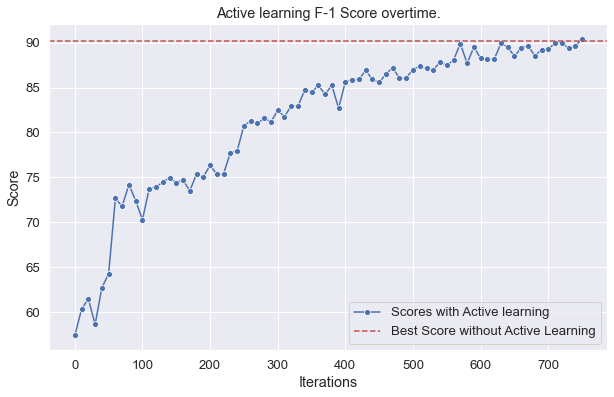

In [18]:
rf = RandomForestClassifier(min_samples_split=2, min_samples_leaf=2, random_state=4444)

rf.fit(X_train, y_train)
f1_standard = get_score(y_test, rf.predict(X_test))[0]

rf.fit(X_initial, y_initial)
f1_active = get_score(y_test, rf.predict(X_test))[0]

print("Before Active learning:")
print(f"\tDataset size: {X_train.shape[0]} samples.")
print(f"\tTest F-1 Score: {f1_standard:.2%}")

print("After Active learning:")
print(f"\tDataset size: {X_initial.shape[0]} samples.")
print(f"\tTest F-1 Score: {f1_active:.2%}")

print(f"Dataset size ratio (Active/Standard): {X_initial.shape[0]/X_train.shape[0]:.2f}")

iterations = [i * 10 for i in range(len(scores))]
data = pd.DataFrame({'Iterations': iterations, 'Score': scores})

plt.figure(figsize=(10, 6))
sns.lineplot(x='Iterations', y='Score', data=data, marker='o', label='Scores with Active learning')
plt.axhline(y=best_score * 100, color='r', linestyle='--', label='Best Score without Active Learning')

plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('Active learning F-1 Score overtime.')
plt.legend()
plt.show()

In [21]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import entropy
from sklearn.metrics import f1_score


X_pool = np.array(X_train.copy())
y_pool = np.array(y_train.copy())

initial_indices = np.random.choice(range(len(X_pool)), size=100, replace=False)
X_initial = X_pool[initial_indices]
y_initial = y_pool[initial_indices]

X_pool = np.delete(X_pool, initial_indices, axis=0)
y_pool = np.delete(y_pool, initial_indices)

rf = RandomForestClassifier(min_samples_split=2, min_samples_leaf=2, random_state=4444)
scores = []

def calculate_entropy(probs):
    return entropy(probs.T) 

for iteration in range(1000):  
    rf.fit(X_initial, y_initial)

    probs = rf.predict_proba(X_pool)
    entropy_values = calculate_entropy(probs)
    highest_entropy_idx = np.argmax(entropy_values) 

    X_initial = np.vstack((X_initial, X_pool[highest_entropy_idx].reshape(1, -1)))
    y_initial = np.append(y_initial, y_pool[highest_entropy_idx])

    X_pool = np.delete(X_pool, highest_entropy_idx, axis=0)
    y_pool = np.delete(y_pool, highest_entropy_idx)

    if iteration % 10 == 0:
        y_pred = rf.predict(X_valid)
        f1 = f1_score(y_valid, y_pred, average='macro')
        scores.append(f1)
        print(f"Iteration {iteration}: Dataset size: {X_initial.shape[0]}, F1 Score: {f1:.2%}")


Iteration 0: Dataset size: 101, F1 Score: 57.06%
Iteration 10: Dataset size: 111, F1 Score: 57.39%
Iteration 20: Dataset size: 121, F1 Score: 61.02%
Iteration 30: Dataset size: 131, F1 Score: 58.11%
Iteration 40: Dataset size: 141, F1 Score: 59.19%
Iteration 50: Dataset size: 151, F1 Score: 59.17%
Iteration 60: Dataset size: 161, F1 Score: 60.23%
Iteration 70: Dataset size: 171, F1 Score: 66.86%
Iteration 80: Dataset size: 181, F1 Score: 67.13%
Iteration 90: Dataset size: 191, F1 Score: 68.39%
Iteration 100: Dataset size: 201, F1 Score: 69.82%
Iteration 110: Dataset size: 211, F1 Score: 69.61%
Iteration 120: Dataset size: 221, F1 Score: 72.22%
Iteration 130: Dataset size: 231, F1 Score: 72.64%
Iteration 140: Dataset size: 241, F1 Score: 75.72%
Iteration 150: Dataset size: 251, F1 Score: 74.15%
Iteration 160: Dataset size: 261, F1 Score: 71.27%
Iteration 170: Dataset size: 271, F1 Score: 72.95%
Iteration 180: Dataset size: 281, F1 Score: 73.67%
Iteration 190: Dataset size: 291, F1 Score

Before Active learning:
	Dataset size: 4286 samples.
	Test F-1 Score: 87.51%
After Active learning:
	Dataset size: 1100 samples.
	Test F-1 Score: 84.43%
Dataset size ratio (Active/Standard): 0.26


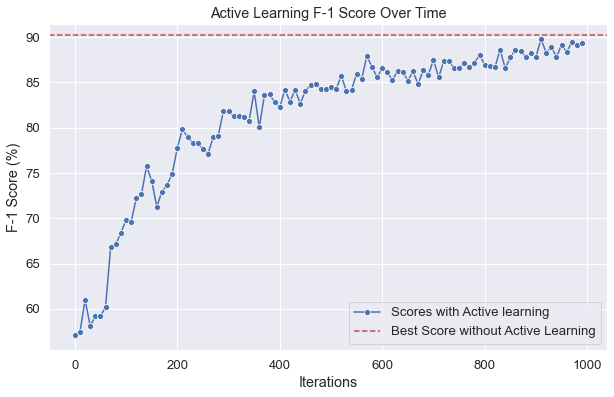

In [23]:
rf = RandomForestClassifier(min_samples_split=2, min_samples_leaf=2, random_state=4444)

rf.fit(X_train, y_train)
f1_standard = f1_score(y_test, rf.predict(X_test), average='macro')

rf.fit(X_initial, y_initial)
f1_active = f1_score(y_test, rf.predict(X_test), average='macro')

print("Before Active learning:")
print(f"\tDataset size: {X_train.shape[0]} samples.")
print(f"\tTest F-1 Score: {f1_standard:.2%}")

print("After Active learning:")
print(f"\tDataset size: {X_initial.shape[0]} samples.")
print(f"\tTest F-1 Score: {f1_active:.2%}")

print(f"Dataset size ratio (Active/Standard): {X_initial.shape[0]/X_train.shape[0]:.2f}")

iterations = [i * 10 for i in range(len(scores))]
data = pd.DataFrame({'Iterations': iterations, 'Score': [score * 100 for score in scores]})  # Scale to percentage

plt.figure(figsize=(10, 6))
sns.lineplot(x='Iterations', y='Score', data=data, marker='o', label='Scores with Active learning')
plt.axhline(y=best_score * 100, color='r', linestyle='--', label='Best Score without Active Learning')

plt.xlabel('Iterations')
plt.ylabel('F-1 Score (%)')
plt.title('Active Learning F-1 Score Over Time')
plt.legend()
plt.show()
